# Redirection Networks - Probabilities

### Marcos Costa Santos Carreira

## Imports

In [1]:
import networkx as nx
# import random as rd
from fractions import Fraction
# from math import factorial, log10
# from collections import Counter
# from collections.abc import Iterable
# from itertools import permutations
from more_itertools import locate
# import functools

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from tqdm.notebook import tqdm

In [4]:
from mpl_toolkits.mplot3d import Axes3D

## Functions

#### Definitions - Initialization

In [5]:
def build_tree(edges):
    g = nx.Graph()
    g.update(edges)
    return g

In [6]:
init = build_tree([(0, 1)])
[init.edges, init.nodes, init.order(), init.size(), init.degree]

[EdgeView([(0, 1)]), NodeView((0, 1)), 2, 1, DegreeView({0: 1, 1: 1})]

In [7]:
def hashk(g):
    return nx.weisfeiler_lehman_graph_hash(g)

#### Data structures for the possible networks

In [188]:
class Network(object):
    def __init__(self, g):
        self._graph = g
        self._hash = hashk(self._graph)
        self._prob = 0
        self.calc_basic()
        
    def calc_basic(self):
        self._n = self._graph.order()
        self._degrees = self._graph.degree
        self._deg_values = dict(self._degrees).values()
        self._max_degree = max(self._deg_values) # d
        self._max_degree_f = Fraction(self._max_degree, self._n) # x
        self._max_degree_i = list(locate(self._deg_values, lambda x: x == self._max_degree))
        self._max_degree_n = len(self._max_degree_i) # m
        self._nodes = list(self._graph.nodes)
        self._leaves = [k for k in self._nodes if self._degrees[k] == 1]
        self._hubs = list(set(self._nodes) - set(self._leaves))
        self._l = len(self._leaves)
        self._h = self._n - self._l
        self._hf = Fraction(self._h, self._n) # y
        self._coord = (self._max_degree_f, self._hf)
        
    def calc_cores_branches(self):
        gc = nx.Graph()
        gc.add_nodes_from(self._graph)
        gc.add_edges_from(self._graph.edges)
        gc.remove_nodes_from(self._leaves)
        gc_degrees = gc.degree
        self._h_degrees = {k: self._degrees[k] for k in self._hubs}
        self._h_nr_leaves = {k: self._degrees[k] - gc_degrees[k] for k in self._hubs}
        self._cores = [k for k in self._hubs if self._h_nr_leaves[k] == 0]
        self._branches = list(set(self._hubs) - set(self._cores))
        self._b = len(self._branches)
        self._c = len(self._cores)
    
    def calc_dph(self, ph):
        if self._h == 0:
            return 1
        else:
            return Fraction(self._n * ph - self._h, self._n * (self._n + 1))

    def calc_mu(self, ph):
        if self._h == 0:
            return 1
        else:
            return Fraction(self._n * ph - self._h, self._h * (self._n + 1))
    
    def calc_mus(self, model='CR'):
        if self._h == 0:
            self._ph = 1
        else:
            if model == 'NR':
                self._ph = Fraction(self._l, self._n)
            elif model == 'XR':
                self._ph = Fraction(self._h, self._n)
            elif model == 'HR':
                self._ph = Fraction(self._l * self._h, self._n * (self._n - 1))
            elif model == 'FR':
                self._ph = Fraction(self._l * self._b, self._n * (self._n - 1))
            else:                 
                self._ph = Fraction(1, self._n) * \
                    sum([Fraction(self._h_nr_leaves[k], self._h_degrees[k]) for k in self._hubs])                   
        self._dph = self.calc_dph(self._ph)
        self._mu = self.calc_mu(self._ph)

    def calc_dpd(self, pd):
        if self._h == 0:
            return 1
        else:
            return Fraction(self._n * pd - self._max_degree, self._n * (self._n + 1))

    def calc_ro(self, pd):
        if self._h == 0:
            return 1
        else:
            return Fraction(self._n * pd - self._max_degree, self._max_degree * (self._n + 1))

    def calc_ros(self, model='CR'):
        self._ch_md = {k: (1 * (k in self._branches)) for k in self._max_degree_i}
        if self._h == 0:
            self._pd = 1
        else:
            if model == 'NR':
                self._pd = Fraction(self._max_degree_n, self._n)
            elif model == 'XR':
                self._pd = Fraction(self._l * self._max_degree_n, self._n * self._h)
            elif model == 'HR':
                self._pd = Fraction(self._max_degree_n, self._n) *\
                    (Fraction(self._l, self._h) +
                     Fraction(self._h - 1, self._n - 1))
            elif model == 'FR':
                self._pd = Fraction(
                    sum([(
                        self._ch_md[k] * Fraction(self._l, self._b) +
                        Fraction(self._b - self._ch_md[k], self._n - 1) +
                        Fraction(self._c + self._ch_md[k] - 1, max(1, self._h - 1)))
                        for k in self._max_degree_i]),
                    self._n)
            else:                 
                self._pd = Fraction(
                    sum([
                        sum([Fraction(1, self._degrees[j]) for j in self._graph.neighbors(k)])
                        for k in self._max_degree_i]),
                    self._n)                
        self._dpd = self.calc_dpd(self._pd)
        self._ro = self.calc_ro(self._pd)
        
    def clear_prob(self, p):
        self._prob = 0        
        
    def update_prob(self, p):
        self._prob = self._prob + p

In [189]:
initN = Network(init)
initN.update_prob(1)
initN.calc_cores_branches()
initN.calc_mus()
initN.calc_ros()

#### Definitions - Iteration

In [87]:
last_n = 17

In [152]:
def next_all(go_list, model_next='NR'):
    gr_dict = {}
    for go in tqdm(go_list):
        g = go._graph
        order = go._n
        nodes = list(go._nodes)
        p = go._prob
        for nd in nodes:
            if model_next == 'NR':
                neighbors = [nd]
            elif model_next == 'CR':
                neighbors = list(g.neighbors(nd))
            elif model_next == 'XR':
                if nd in go._leaves:
                    neighbors = list(go._hubs)
                    if order == 2:
                        neighbors = list(go._nodes)
                        neighbors.remove(nd)
                else:
                    neighbors = list(go._leaves)
            elif model_next == 'HR':
                if nd in go._leaves:
                    neighbors = list(go._hubs)
                    if order == 2:
                        neighbors = list(go._nodes)
                        neighbors.remove(nd)
                else:
                    neighbors = list(go._nodes)
                    neighbors.remove(nd)
            elif model_next == 'FR':
                if nd in go._leaves:
                    neighbors = list(go._branches)
                    if order == 2:
                        neighbors = list(go._nodes)
                        neighbors.remove(nd)
                elif nd in go._branches:
                    neighbors = list(go._nodes)
                    neighbors.remove(nd)
                else:
                    neighbors = list(go._hubs)
                    neighbors.remove(nd)
            else:
                neighbors = [nd]
            neigorder = len(neighbors)
            for k in neighbors:
                gc = nx.Graph()
                gc.add_nodes_from(g)
                gc.add_edges_from(g.edges)
                attach = k
                gc.add_edge(attach, order)
                hash_gc = hashk(gc)
                if hash_gc in gr_dict:
                    new_g = gr_dict[hash_gc]
                else:
                    new_g = Network(gc)
                    new_g.calc_cores_branches()
                    new_g.calc_mus(model=model_next)
                    new_g.calc_ros(model=model_next)
                new_g.update_prob(p * Fraction(1, order * neigorder))
                gr_dict[hash_gc] = new_g
    return list(gr_dict.values())

In [153]:
def next_check(go, model_next='NR', output='B'):
    g = go._graph
    order = go._n
    nodes = list(go._nodes)
    p = go._prob
    h = go._h
    d = go._max_degree
    ph = 0
    pd = 0
    for nd in nodes:
        if model_next == 'NR':
            neighbors = [nd]
        elif model_next == 'CR':
            neighbors = list(g.neighbors(nd))
        elif model_next == 'XR':
            if nd in go._leaves:
                neighbors = list(go._hubs)
                if order == 2:
                    neighbors = list(go._nodes)
                    neighbors.remove(nd)
            else:
                neighbors = list(go._leaves)
        elif model_next == 'HR':
            if nd in go._leaves:
                neighbors = list(go._hubs)
                if order == 2:
                    neighbors = list(go._nodes)
                    neighbors.remove(nd)
            else:
                neighbors = list(go._nodes)
                neighbors.remove(nd)
        elif model_next == 'FR':
            if nd in go._leaves:
                neighbors = list(go._branches)
                if order == 2:
                    neighbors = list(go._nodes)
                    neighbors.remove(nd)
            elif nd in go._branches:
                neighbors = list(go._nodes)
                neighbors.remove(nd)
            else:
                neighbors = list(go._hubs)
                neighbors.remove(nd)
        else:
            neighbors = [nd]
        neigorder = len(neighbors)
        for k in neighbors:
            gc = nx.Graph()
            gc.add_nodes_from(g)
            gc.add_edges_from(g.edges)
            attach = k
            gc.add_edge(attach, order)
            new_g = Network(gc)
            if new_g._h > h:
                ph = ph + Fraction(1, order * neigorder)
            if new_g._max_degree > d:
                pd = pd + Fraction(1, order * neigorder)
    if output == 'B':
        return ((ph == go._ph) and (pd == go._pd))
    else:
        return [ph, go._ph, pd, go._pd]

In [122]:
def check_row(go_list, model_next='NR'):
    return all([next_check(go, model_next, output='B') for go in go_list])

In [12]:
def model_dicts(model, n):
    dict_model = {2: [initN]}
    for j in tqdm(range(3, n + 1)):
        prev_gos = dict_model[j - 1]
        next_gos = next_all(prev_gos, model_next=model)
        dict_model[j] = next_gos
    return dict_model

In [15]:
def feat_dicts(model_d):
    dict_dfs = {}
    keys = model_d.keys()
    for j in tqdm(keys):
        list_df = []
        dn = model_d[j]
        for gok in tqdm(dn):
            new_row = [gok._h, gok._hf, gok._max_degree, gok._max_degree_f, gok._prob,
                       gok._ph, gok._pd, gok._dph, gok._dpd, gok._mu, gok._ro]
            list_df = list_df + [new_row]
        df_key = pd.DataFrame(list_df, columns=['Nucl', 'NuclF', 'MaxD', 'MaxDF', 'Prob',
                                                  'PH1', 'PD1', 'DPH', 'DPD', 'Mu', 'Ro'])
        dict_dfs[j] = df_key
    return dict_dfs

## Run

### No redirection

In [106]:
%%time

dict_nr = model_dicts('NR', last_n)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/551 [00:00<?, ?it/s]

  0%|          | 0/1301 [00:00<?, ?it/s]

  0%|          | 0/3159 [00:00<?, ?it/s]

  0%|          | 0/7741 [00:00<?, ?it/s]

  0%|          | 0/19320 [00:00<?, ?it/s]

CPU times: user 1min 1s, sys: 657 ms, total: 1min 1s
Wall time: 1min 1s


In [107]:
%%time

dict_dfs_nr = feat_dicts(dict_nr)

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/551 [00:00<?, ?it/s]

  0%|          | 0/1301 [00:00<?, ?it/s]

  0%|          | 0/3159 [00:00<?, ?it/s]

  0%|          | 0/7741 [00:00<?, ?it/s]

  0%|          | 0/19320 [00:00<?, ?it/s]

  0%|          | 0/48629 [00:00<?, ?it/s]

CPU times: user 4.08 s, sys: 43.4 ms, total: 4.13 s
Wall time: 4.11 s


In [108]:
dict_pivots_nr = {n: dict_dfs_nr[n].pivot_table(values='Prob', index=['NuclF'], columns=['MaxDF'], aggfunc='sum')
                  for n in tqdm(range(2, last_n + 1))}

  0%|          | 0/16 [00:00<?, ?it/s]

In [109]:
dict_groups_nr = {n: dict_dfs_nr[n].loc[:,['NuclF', 'MaxDF', 'Prob', 'DPH', 'DPD', 'Mu', 'Ro']]\
                  .groupby(['NuclF', 'MaxDF', 'DPH', 'DPD', 'Mu', 'Ro']).apply('sum') for n in tqdm(range(2, last_n + 1))}

  0%|          | 0/16 [00:00<?, ?it/s]

In [54]:
%%time

check_row(dict_nr[last_n - 1], model_next='NR')

CPU times: user 30.3 s, sys: 67.9 ms, total: 30.3 s
Wall time: 30.3 s


True

In [55]:
%%time

check_row(dict_nr[last_n], model_next='NR')

CPU times: user 1min 24s, sys: 167 ms, total: 1min 24s
Wall time: 1min 24s


True

In [122]:
[len(dict_nr[n]) for n in range(2, last_n + 1)] == [1, 1, 2, 3, 6, 11, 23, 47, 106, 235, 551, 1301, 3159, 7741, 19320, 48629]

True

In [123]:
all([sum([(dict_nr[n])[k]._prob for k in range(len(dict_nr[n]))]) == 1 for n in range(2, last_n + 1)])

True

### Complete redirection

In [22]:
%%time

dict_cr = model_dicts('CR', last_n)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/551 [00:00<?, ?it/s]

  0%|          | 0/1301 [00:00<?, ?it/s]

  0%|          | 0/3159 [00:00<?, ?it/s]

  0%|          | 0/7741 [00:00<?, ?it/s]

  0%|          | 0/19320 [00:00<?, ?it/s]

CPU times: user 1min 38s, sys: 934 ms, total: 1min 39s
Wall time: 1min 39s


In [23]:
%%time

dict_dfs_cr = feat_dicts(dict_cr)

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/551 [00:00<?, ?it/s]

  0%|          | 0/1301 [00:00<?, ?it/s]

  0%|          | 0/3159 [00:00<?, ?it/s]

  0%|          | 0/7741 [00:00<?, ?it/s]

  0%|          | 0/19320 [00:00<?, ?it/s]

  0%|          | 0/48629 [00:00<?, ?it/s]

CPU times: user 5.98 s, sys: 53.9 ms, total: 6.04 s
Wall time: 6.01 s


In [32]:
dict_pivots_cr = {n: dict_dfs_cr[n].pivot_table(values='Prob', index=['NuclF'], columns=['MaxDF'], aggfunc='sum')
                  for n in tqdm(range(2, last_n + 1))}

  0%|          | 0/16 [00:00<?, ?it/s]

In [33]:
dict_groups_cr = {n: dict_dfs_cr[n].loc[:,['NuclF', 'MaxDF', 'Prob', 'DPH', 'DPD', 'Mu', 'Ro']]\
                  .groupby(['NuclF', 'MaxDF', 'DPH', 'DPD', 'Mu', 'Ro']).apply('sum') for n in tqdm(range(2, last_n + 1))}

  0%|          | 0/16 [00:00<?, ?it/s]

In [56]:
%%time

check_row(dict_cr[last_n - 1], model_next='CR')

CPU times: user 56.2 s, sys: 110 ms, total: 56.4 s
Wall time: 56.4 s


True

In [57]:
%%time

check_row(dict_cr[last_n], model_next='CR')

CPU times: user 2min 41s, sys: 340 ms, total: 2min 42s
Wall time: 2min 42s


True

In [116]:
[len(dict_cr[n]) for n in range(2, last_n + 1)] == [1, 1, 2, 3, 6, 11, 23, 47, 106, 235, 551, 1301, 3159, 7741, 19320, 48629]

True

In [117]:
all([sum([(dict_cr[n])[k]._prob for k in range(len(dict_nr[n]))]) == 1 for n in range(2, last_n + 1)])

True

### Fuzzy redirection

In [154]:
%%time

dict_fr = model_dicts('FR', last_n)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/551 [00:00<?, ?it/s]

  0%|          | 0/1301 [00:00<?, ?it/s]

  0%|          | 0/3159 [00:00<?, ?it/s]

  0%|          | 0/7741 [00:00<?, ?it/s]

  0%|          | 0/19320 [00:00<?, ?it/s]

CPU times: user 6min 36s, sys: 2.38 s, total: 6min 38s
Wall time: 6min 37s


In [155]:
%%time

dict_dfs_fr = feat_dicts(dict_fr)

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/551 [00:00<?, ?it/s]

  0%|          | 0/1301 [00:00<?, ?it/s]

  0%|          | 0/3159 [00:00<?, ?it/s]

  0%|          | 0/7741 [00:00<?, ?it/s]

  0%|          | 0/19320 [00:00<?, ?it/s]

  0%|          | 0/48629 [00:00<?, ?it/s]

CPU times: user 3.91 s, sys: 33.9 ms, total: 3.94 s
Wall time: 3.93 s


In [156]:
dict_pivots_fr = {n: dict_dfs_fr[n].pivot_table(values='Prob', index=['NuclF'], columns=['MaxDF'], aggfunc='sum')
                  for n in tqdm(range(2, last_n + 1))}

  0%|          | 0/16 [00:00<?, ?it/s]

In [209]:
dict_groups_fr = {n: dict_dfs_fr[n].loc[:,['NuclF', 'MaxDF', 'Prob', 'DPH', 'DPD', 'Mu', 'Ro']]\
                  .groupby(['NuclF', 'MaxDF', 'DPH', 'DPD', 'Mu', 'Ro']).apply('sum') for n in tqdm(range(2, last_n + 1))}

  0%|          | 0/16 [00:00<?, ?it/s]

In [162]:
%%time

check_row(dict_fr[8], model_next='FR')

CPU times: user 46.2 ms, sys: 965 µs, total: 47.2 ms
Wall time: 46.4 ms


True

In [172]:
%%time

check_row(dict_fr[last_n - 1], model_next='FR')

CPU times: user 4min 33s, sys: 366 ms, total: 4min 33s
Wall time: 4min 33s


True

In [173]:
%%time

check_row(dict_fr[last_n], model_next='FR')

CPU times: user 13min 31s, sys: 1.02 s, total: 13min 32s
Wall time: 13min 33s


True

In [167]:
[len(dict_fr[n]) for n in range(2, last_n + 1)] == [1, 1, 2, 3, 6, 11, 23, 47, 106, 235, 551, 1301, 3159, 7741, 19320, 48629]

True

In [168]:
all([sum([(dict_fr[n])[k]._prob for k in range(len(dict_nr[n]))]) == 1 for n in range(2, last_n + 1)])

True

### Hub redirection

In [212]:
%%time

dict_hr = model_dicts('HR', last_n)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/551 [00:00<?, ?it/s]

  0%|          | 0/1301 [00:00<?, ?it/s]

  0%|          | 0/3159 [00:00<?, ?it/s]

  0%|          | 0/7741 [00:00<?, ?it/s]

  0%|          | 0/19320 [00:00<?, ?it/s]

CPU times: user 8min 27s, sys: 3.15 s, total: 8min 30s
Wall time: 8min 29s


In [213]:
%%time

dict_dfs_hr = feat_dicts(dict_hr)

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/551 [00:00<?, ?it/s]

  0%|          | 0/1301 [00:00<?, ?it/s]

  0%|          | 0/3159 [00:00<?, ?it/s]

  0%|          | 0/7741 [00:00<?, ?it/s]

  0%|          | 0/19320 [00:00<?, ?it/s]

  0%|          | 0/48629 [00:00<?, ?it/s]

CPU times: user 3.79 s, sys: 36.2 ms, total: 3.83 s
Wall time: 3.82 s


In [214]:
dict_pivots_hr = {n: dict_dfs_hr[n].pivot_table(values='Prob', index=['NuclF'], columns=['MaxDF'], aggfunc='sum')
                  for n in tqdm(range(2, last_n + 1))}

  0%|          | 0/16 [00:00<?, ?it/s]

In [215]:
dict_groups_hr = {n: dict_dfs_hr[n].loc[:,['NuclF', 'MaxDF', 'Prob', 'DPH', 'DPD', 'Mu', 'Ro']]\
                  .groupby(['NuclF', 'MaxDF', 'DPH', 'DPD', 'Mu', 'Ro']).apply('sum') for n in tqdm(range(2, last_n + 1))}

  0%|          | 0/16 [00:00<?, ?it/s]

In [216]:
%%time

check_row(dict_hr[8], model_next='HR')

CPU times: user 54 ms, sys: 835 µs, total: 54.8 ms
Wall time: 54.2 ms


True

In [220]:
%%time

check_row(dict_hr[last_n - 1], model_next='HR')

CPU times: user 5min 46s, sys: 710 ms, total: 5min 47s
Wall time: 5min 47s


True

In [221]:
%%time

check_row(dict_hr[last_n], model_next='HR')

CPU times: user 17min 28s, sys: 1.43 s, total: 17min 29s
Wall time: 17min 30s


True

In [217]:
[len(dict_hr[n]) for n in range(2, last_n + 1)] == [1, 1, 2, 3, 6, 11, 23, 47, 106, 235, 551, 1301, 3159, 7741, 19320, 48629]

True

In [218]:
all([sum([(dict_hr[n])[k]._prob for k in range(len(dict_nr[n]))]) == 1 for n in range(2, last_n + 1)])

True

### Cross redirection

In [190]:
%%time

dict_xr = model_dicts('XR', last_n)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/551 [00:00<?, ?it/s]

  0%|          | 0/1301 [00:00<?, ?it/s]

  0%|          | 0/3159 [00:00<?, ?it/s]

  0%|          | 0/7741 [00:00<?, ?it/s]

  0%|          | 0/19320 [00:00<?, ?it/s]

CPU times: user 5min 53s, sys: 2.02 s, total: 5min 55s
Wall time: 5min 54s


In [191]:
%%time

dict_dfs_xr = feat_dicts(dict_xr)

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/551 [00:00<?, ?it/s]

  0%|          | 0/1301 [00:00<?, ?it/s]

  0%|          | 0/3159 [00:00<?, ?it/s]

  0%|          | 0/7741 [00:00<?, ?it/s]

  0%|          | 0/19320 [00:00<?, ?it/s]

  0%|          | 0/48629 [00:00<?, ?it/s]

CPU times: user 4.21 s, sys: 38.4 ms, total: 4.25 s
Wall time: 4.23 s


In [192]:
dict_pivots_xr = {n: dict_dfs_xr[n].pivot_table(values='Prob', index=['NuclF'], columns=['MaxDF'], aggfunc='sum')
                  for n in tqdm(range(2, last_n + 1))}

  0%|          | 0/16 [00:00<?, ?it/s]

In [193]:
dict_groups_xr = {n: dict_dfs_xr[n].loc[:,['NuclF', 'MaxDF', 'Prob', 'DPH', 'DPD', 'Mu', 'Ro']]\
                  .groupby(['NuclF', 'MaxDF', 'DPH', 'DPD', 'Mu', 'Ro']).apply('sum') for n in tqdm(range(2, last_n + 1))}

  0%|          | 0/16 [00:00<?, ?it/s]

In [199]:
%%time

check_row(dict_xr[8], model_next='XR')

CPU times: user 41.7 ms, sys: 959 µs, total: 42.7 ms
Wall time: 41.9 ms


True

In [200]:
%%time

check_row(dict_xr[last_n - 1], model_next='XR')

CPU times: user 4min 1s, sys: 335 ms, total: 4min 1s
Wall time: 4min 1s


True

In [201]:
%%time

check_row(dict_xr[last_n], model_next='XR')

CPU times: user 12min 5s, sys: 1.23 s, total: 12min 6s
Wall time: 12min 6s


True

In [202]:
[len(dict_xr[n]) for n in range(2, last_n + 1)] == [1, 1, 2, 3, 6, 11, 23, 47, 106, 235, 551, 1301, 3159, 7741, 19320, 48629]

True

In [203]:
all([sum([(dict_xr[n])[k]._prob for k in range(len(dict_nr[n]))]) == 1 for n in range(2, last_n + 1)])

True

## Compare

### Functions

In [25]:
def plot_probs(df, col1, col2, col3, x_lim=(0, 1), y_lim=(0, 1)):
    fig = plt.figure(figsize=(8, 8))
    ax = plt.axes(projection='3d')
    # ax.scatter3D(df[col1], df[col2], df[colprob])
    ax.stem(df[col1], df[col2], df[col3])
    ax.set_xlabel(col1)
    ax.set_ylabel(col2)
    ax.set_zlabel(col3)
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    plt.show()

In [26]:
def plot_quiver(title, df, x, y, u, v, scale_arrow=1, size_fig=6, x_lim=(0, 1), y_lim=(0, 1)):
    fig = plt.figure(figsize=(size_fig, size_fig))
    ax = plt.axes()
    um = (df.pivot(index=y, columns=x, values=u) * 1.).fillna(0)
    vm = (df.pivot(index=y, columns=x, values=v) * 1.).fillna(0)
    xm = (um.columns.values).astype(float)
    ym = (um.index.values).astype(float)
    plt.quiver(xm, ym, um.values, vm.values, scale=scale_arrow, minlength=0, color='r')
    plt.scatter(x=df[x], y=df[y], color='b', s=5)
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    ax.set_title(title)
    plt.show()

In [27]:
def gen_df(df):
    newdf = df.reset_index()
    newdf['WDPH'] = newdf['DPH'] * newdf['Prob']
    newdf['WDPD'] = newdf['DPD'] * newdf['Prob']
    newdf['WMu'] = newdf['Mu'] * newdf['Prob']
    newdf['WRo'] = newdf['Ro'] * newdf['Prob']
    a = (newdf[['NuclF', 'MaxDF', 'WDPH', 'WDPD', 'WMu', 'WRo']].groupby(['NuclF', 'MaxDF']).sum())
    b = (newdf[['NuclF', 'MaxDF', 'Prob']].groupby(['NuclF', 'MaxDF']).sum())
    ab1 = a['WDPH'] / b['Prob'] 
    ab2 = a['WDPD'] / b['Prob']
    ab3 = a['WMu'] / b['Prob'] 
    ab4 = a['WRo'] / b['Prob']
    return pd.DataFrame({'Prob': b['Prob'], 'DPH': ab1, 'DPD': ab2, 'Mu': ab3, 'Ro': ab4}).reset_index()

In [28]:
def plots_quiver(title, dict_groups, range_n, x='MaxDF', y='NuclF', u='DPD', v='DPH',
                 scale_arrow=1, size_fig=6, x_lim=(0, 1), y_lim=(0, 1)):
    for n in range_n:
        df = gen_df(dict_groups[n])
        plot_quiver(title + ' ; n = ' + str(n), df, x, y, u, v,
                    scale_arrow=scale_arrow, size_fig=size_fig, x_lim=x_lim, y_lim=y_lim)

### No redirection

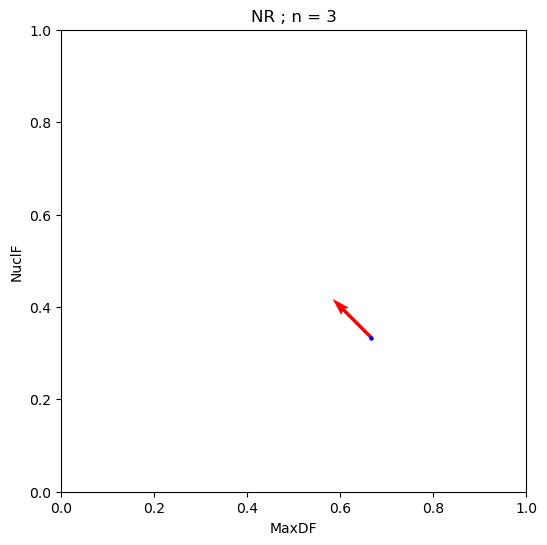

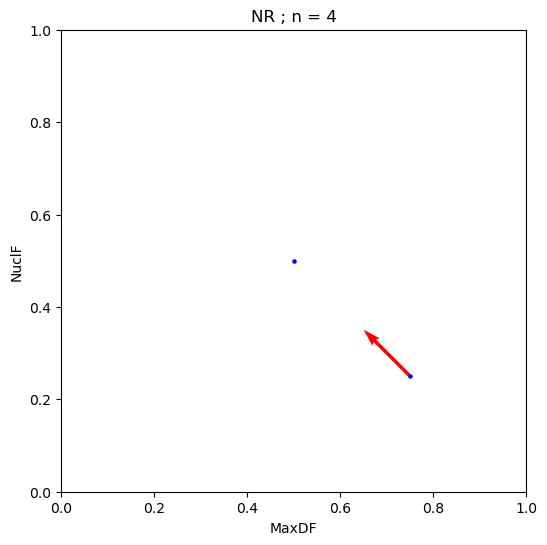

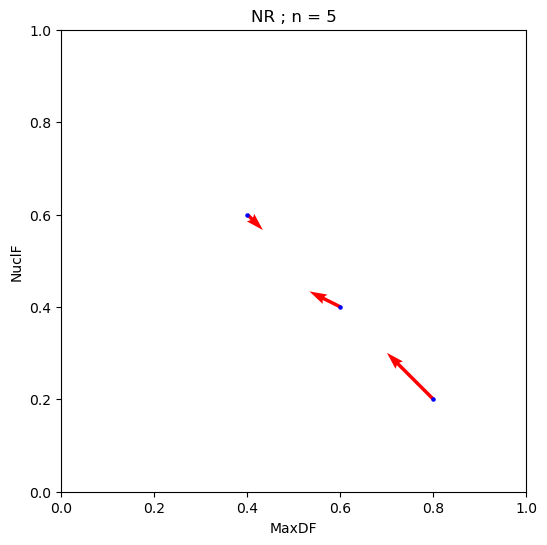

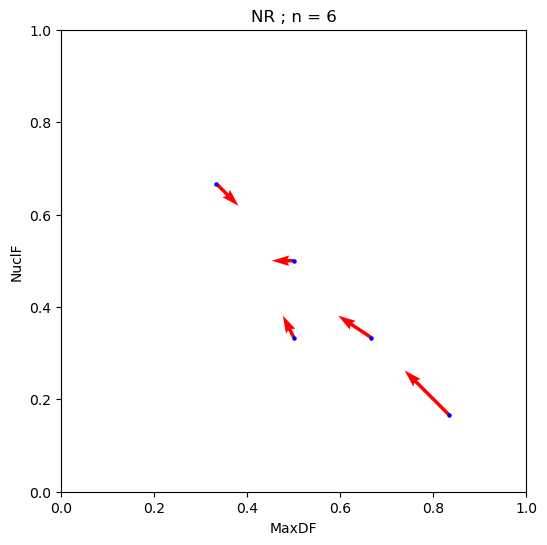

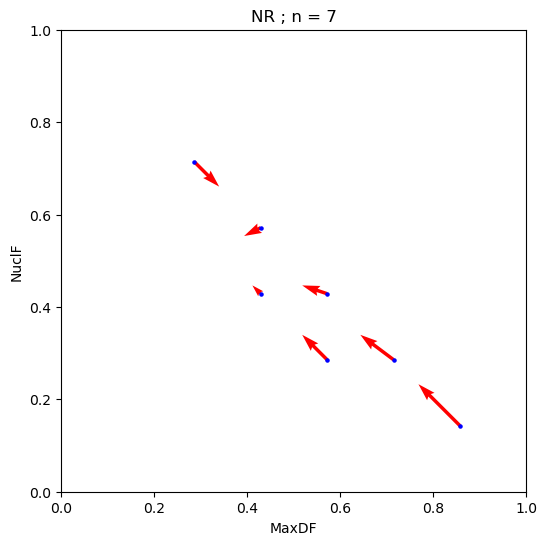

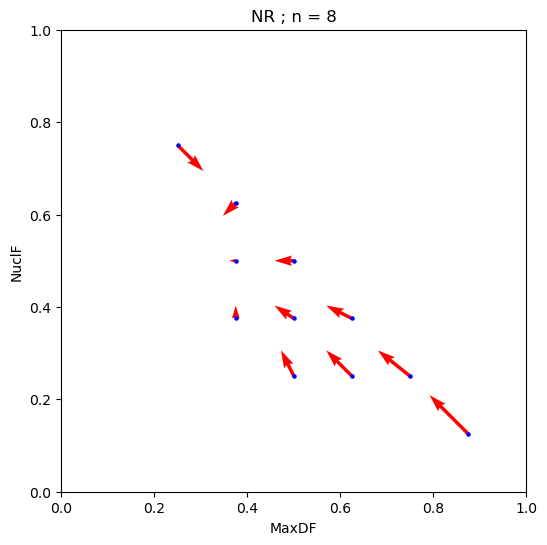

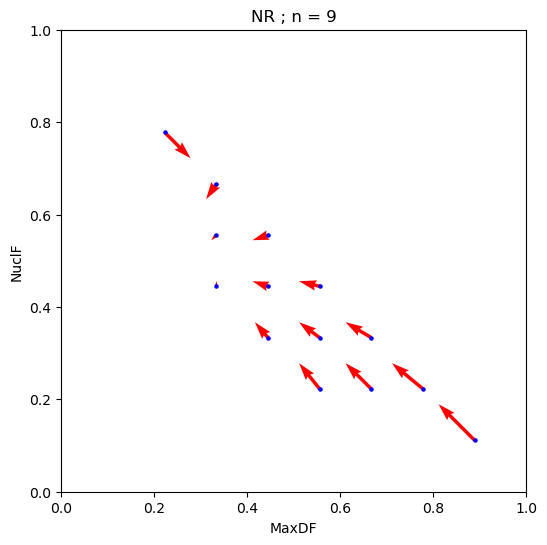

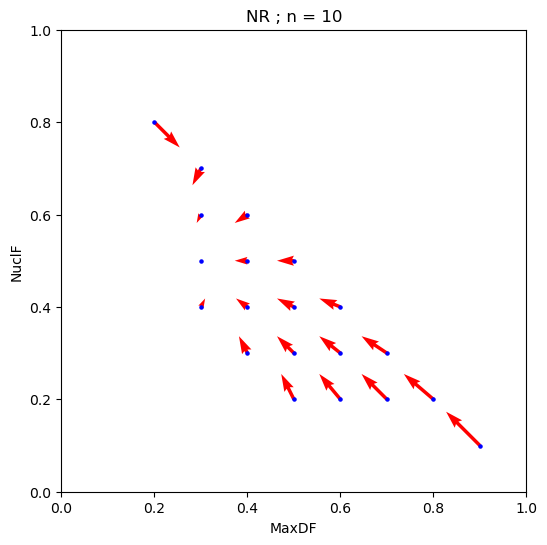

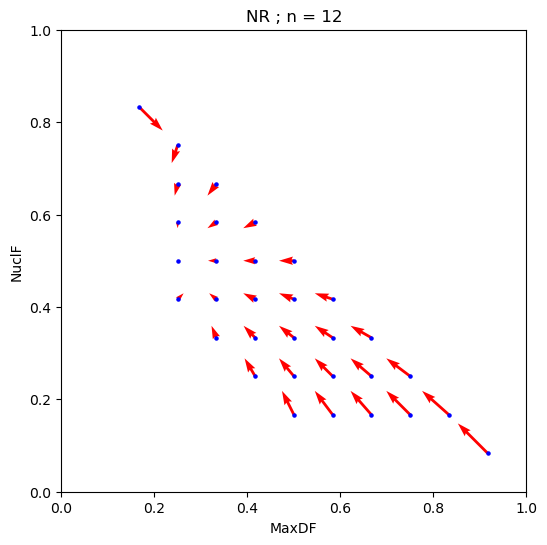

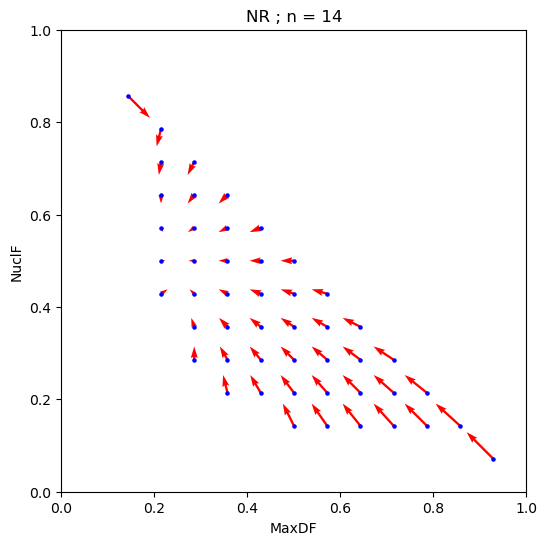

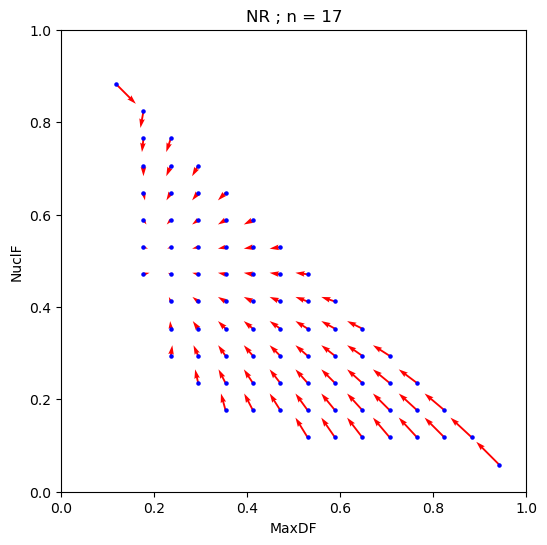

In [222]:
plots_quiver('NR', dict_groups_nr, [3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 17], size_fig=6)

### Cross redirection

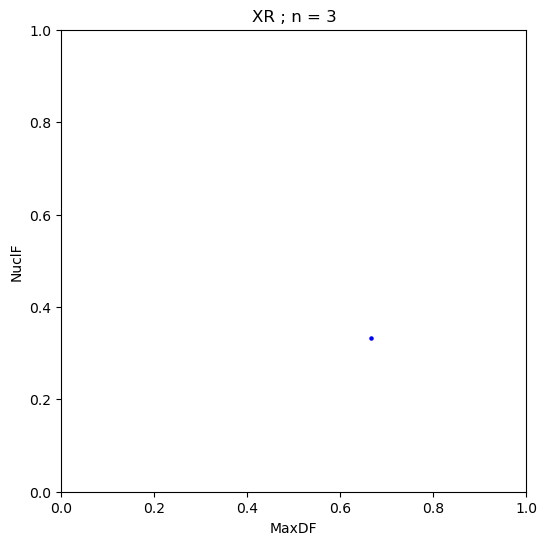

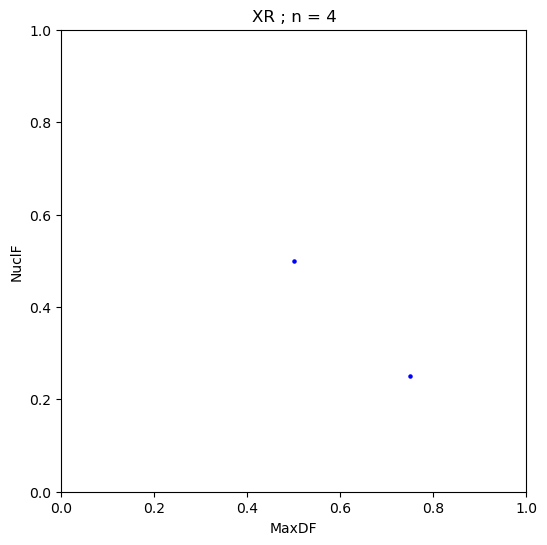

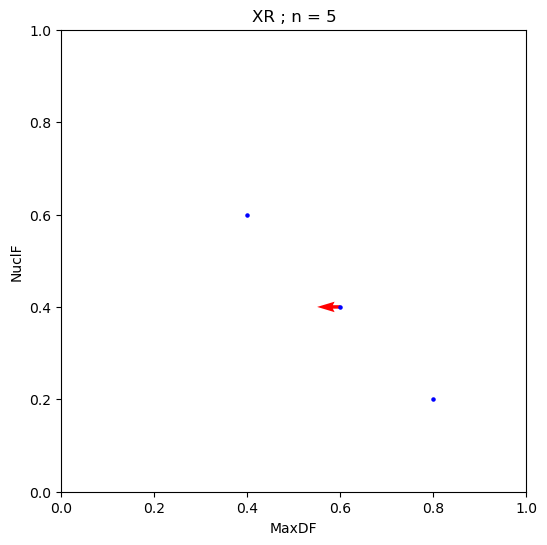

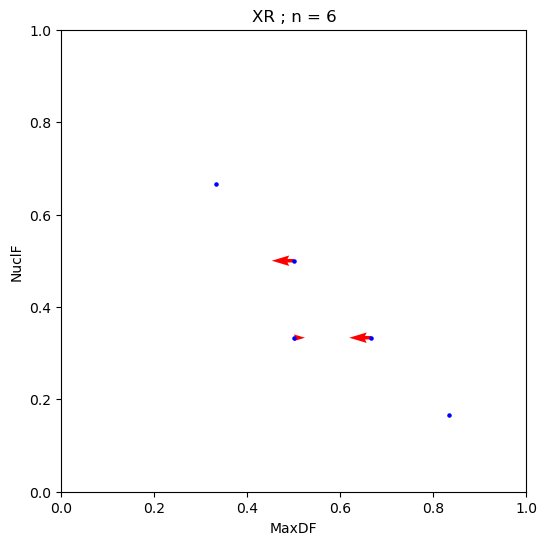

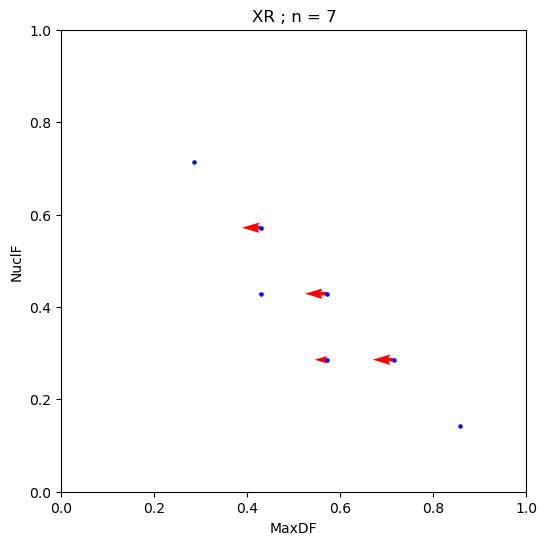

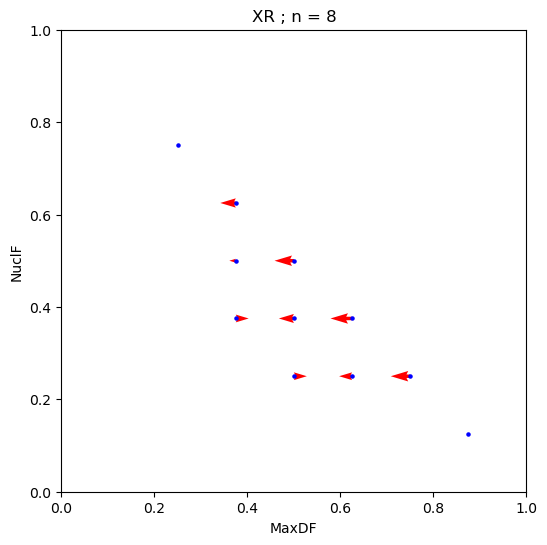

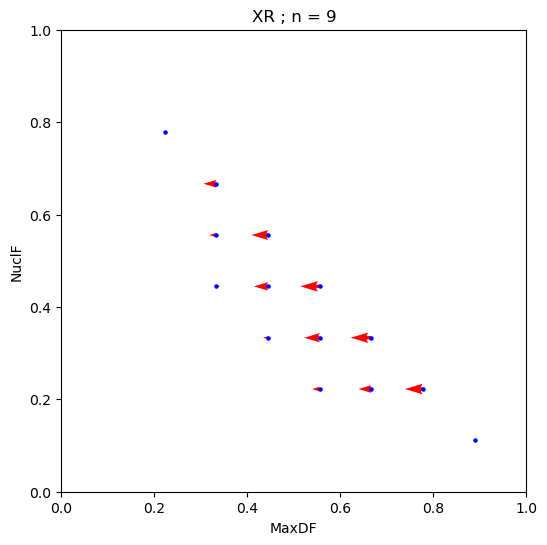

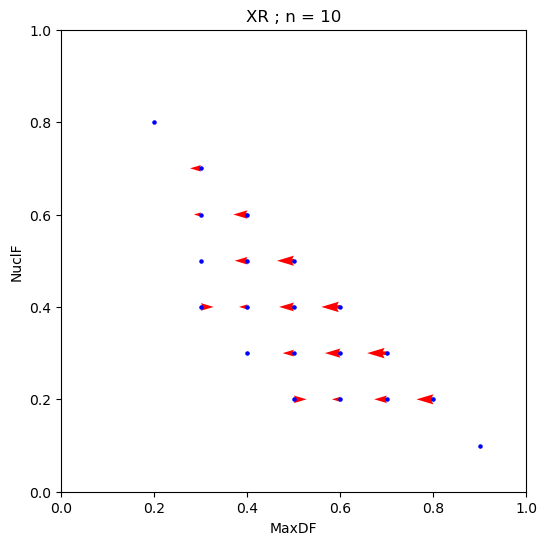

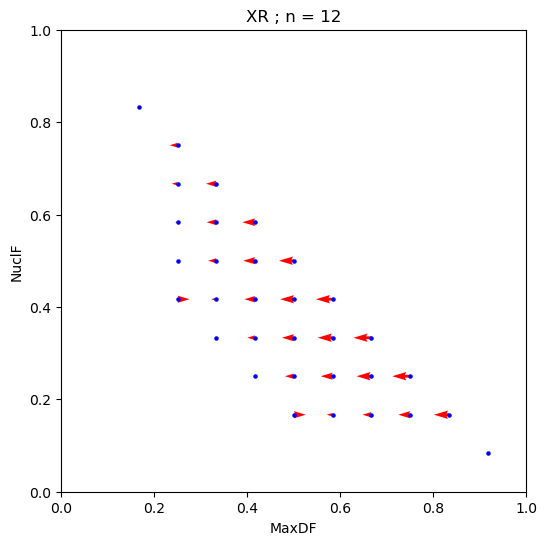

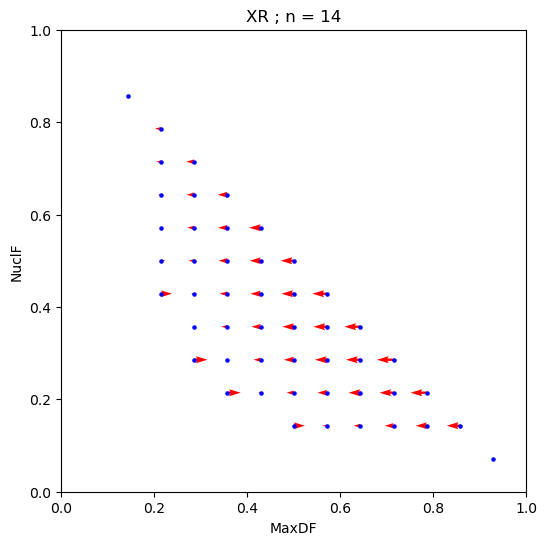

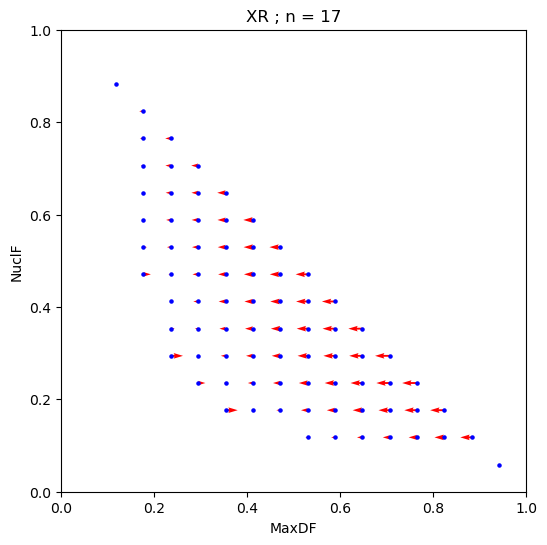

In [223]:
plots_quiver('XR', dict_groups_xr, [3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 17], size_fig=6)

### Fuzzy redirection

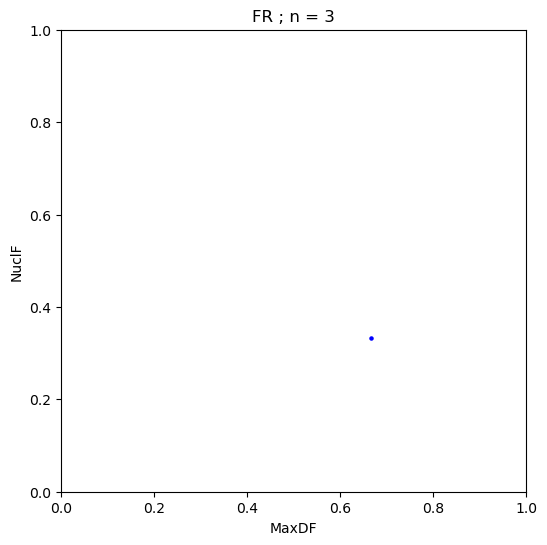

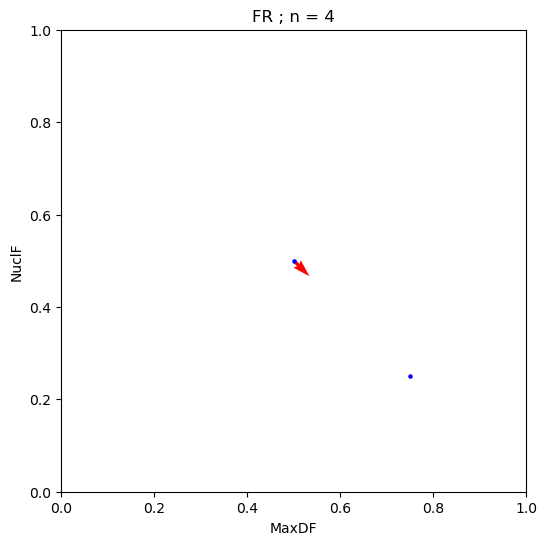

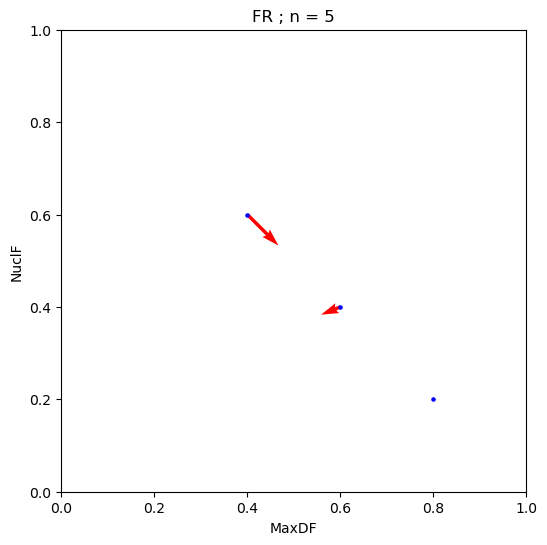

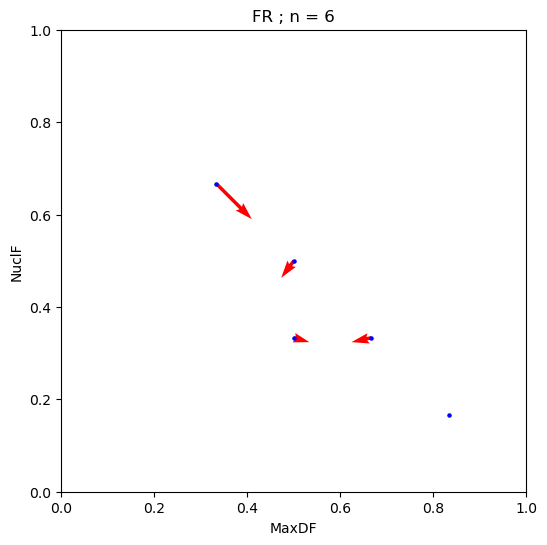

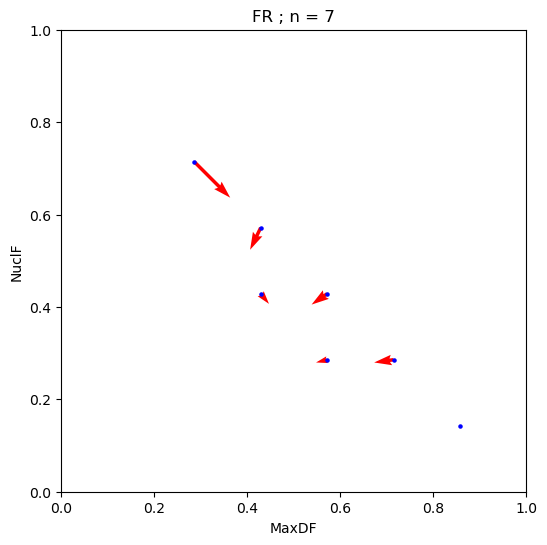

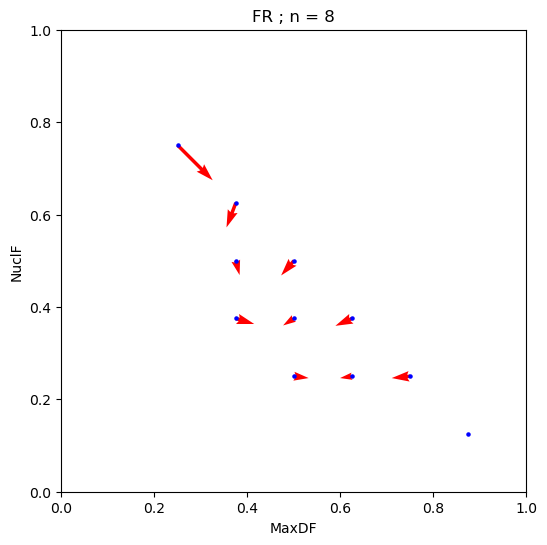

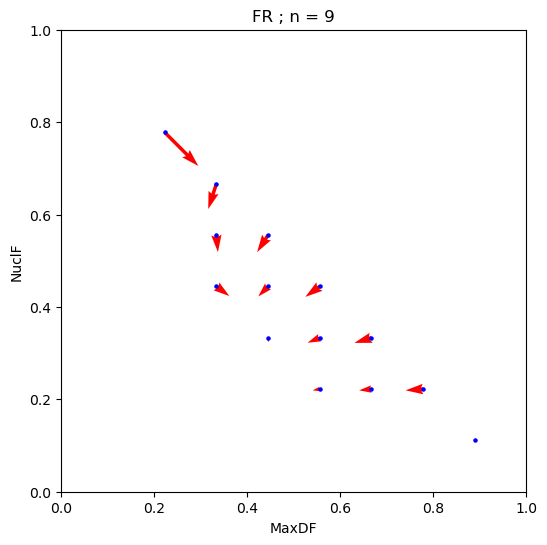

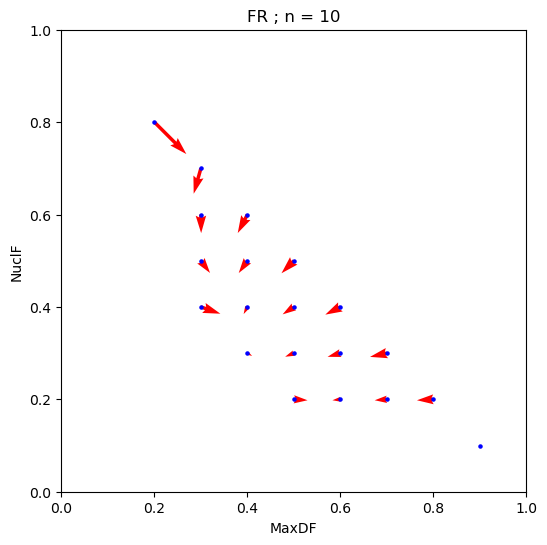

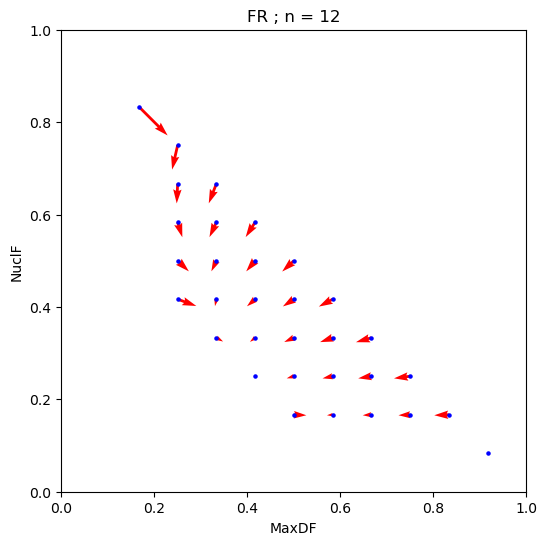

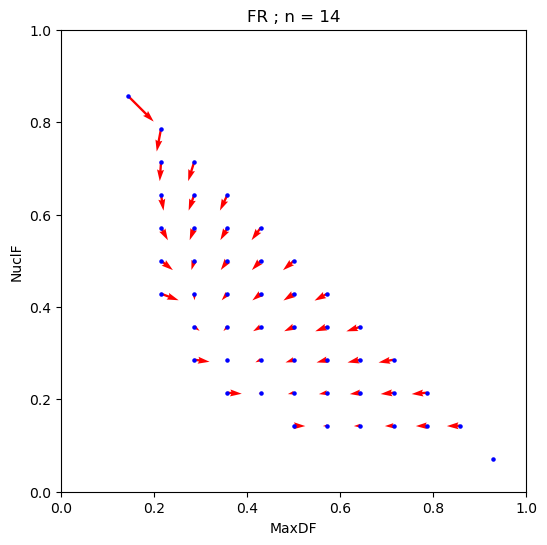

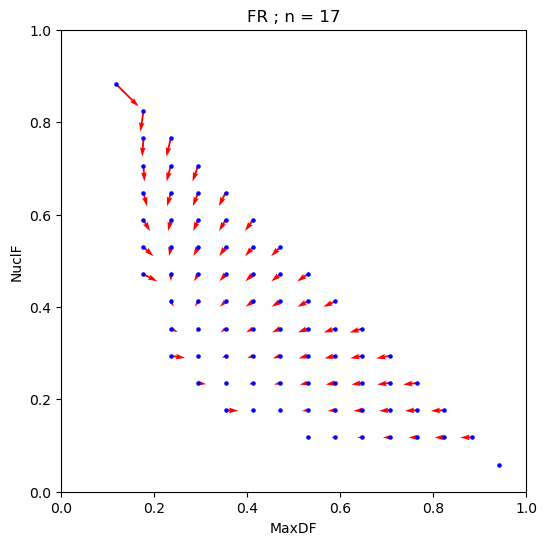

In [210]:
plots_quiver('FR', dict_groups_fr, [3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 17], size_fig=6)

### Hub redirection

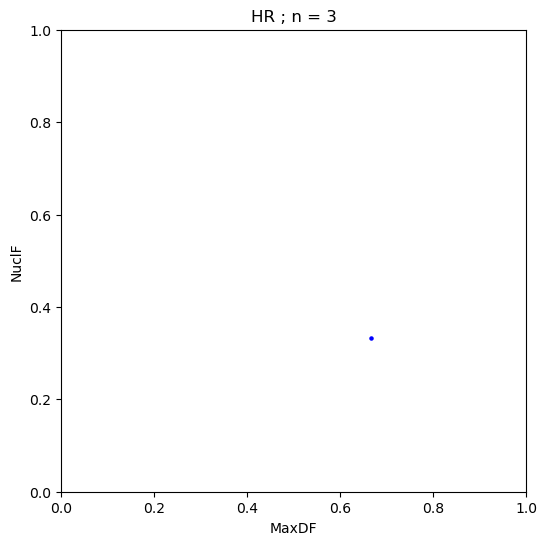

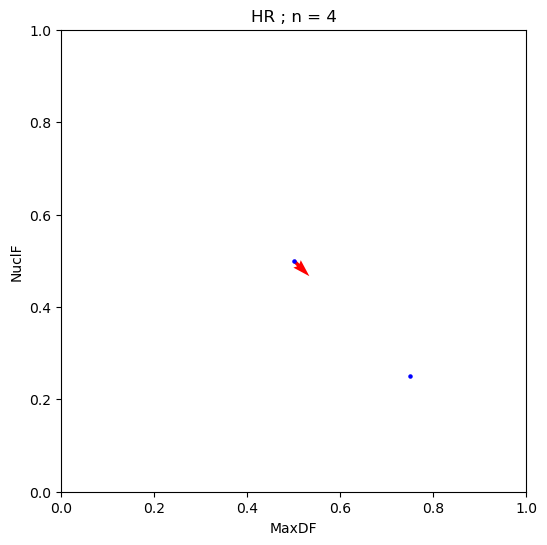

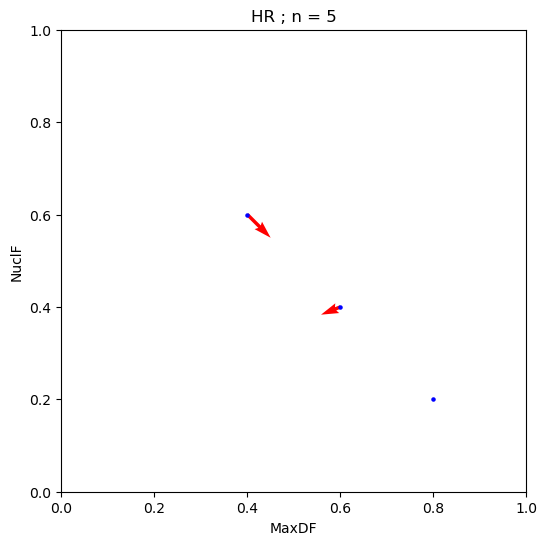

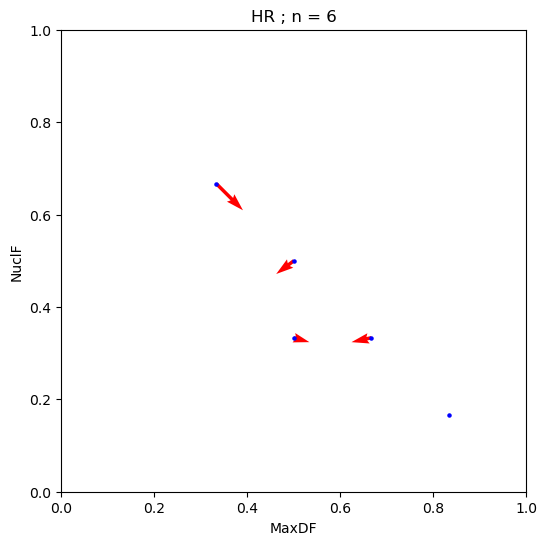

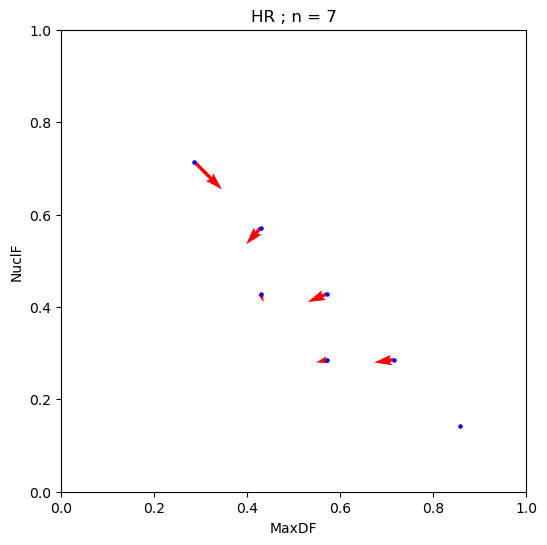

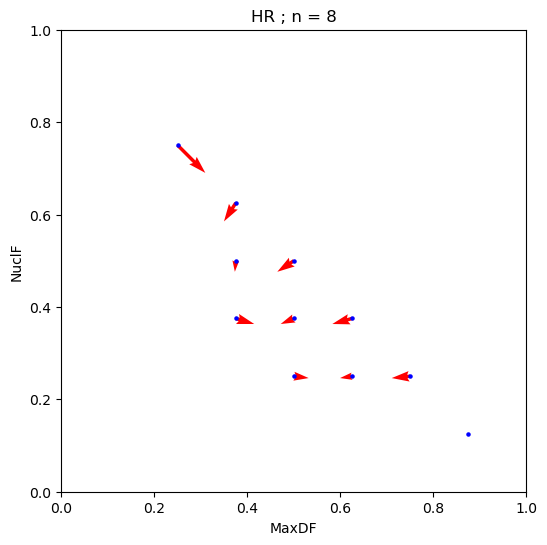

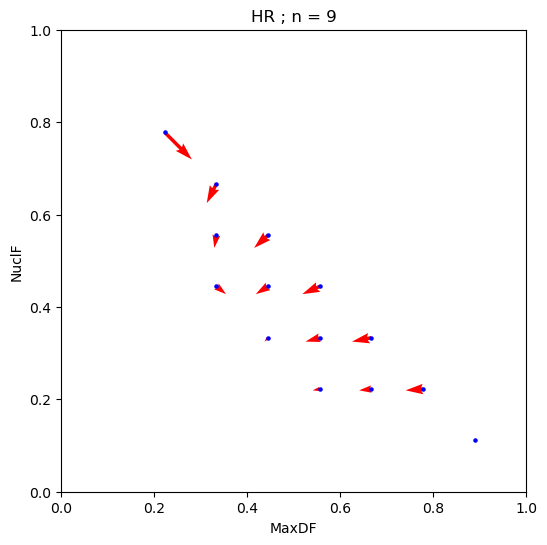

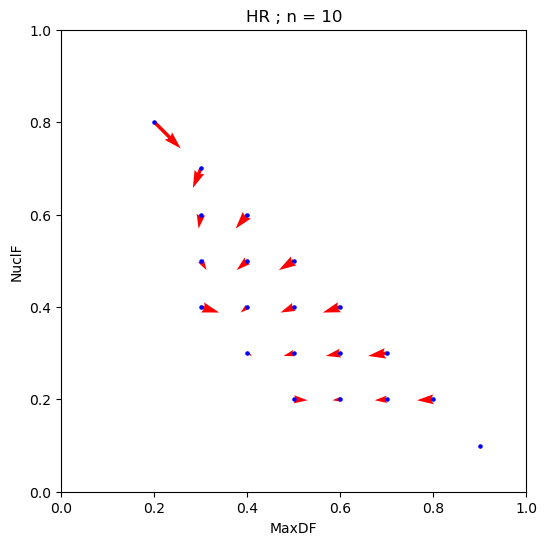

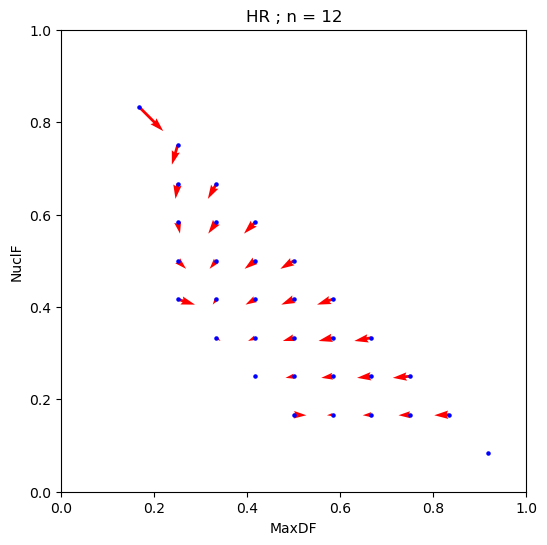

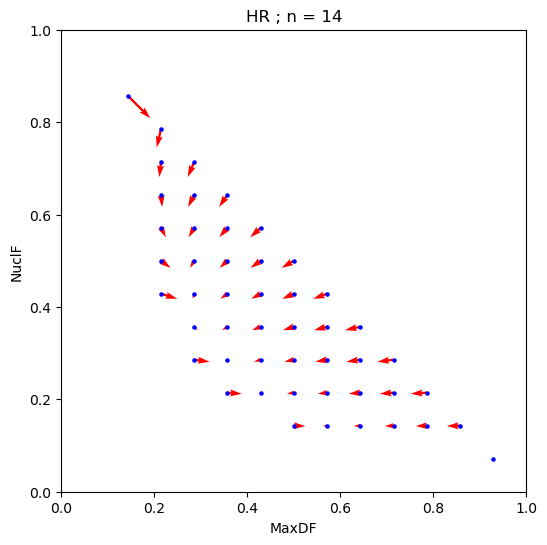

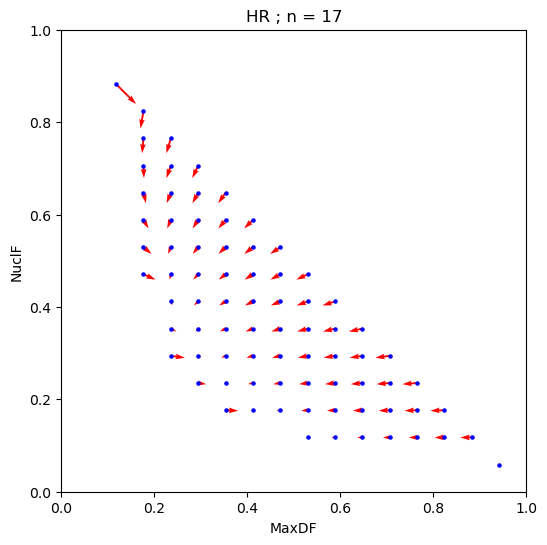

In [219]:
plots_quiver('HR', dict_groups_hr, [3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 17], size_fig=6)

### Complete redirection

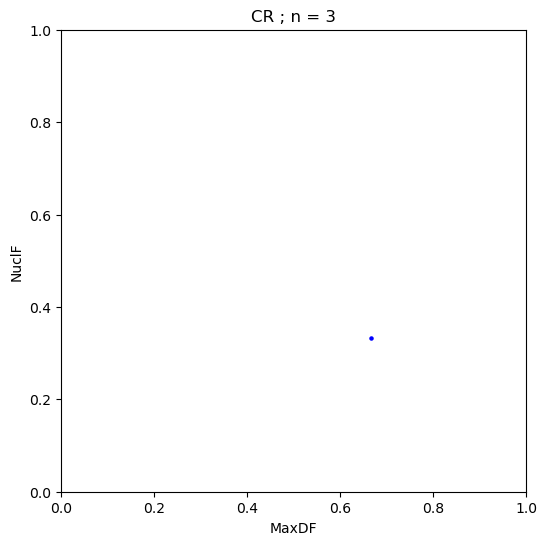

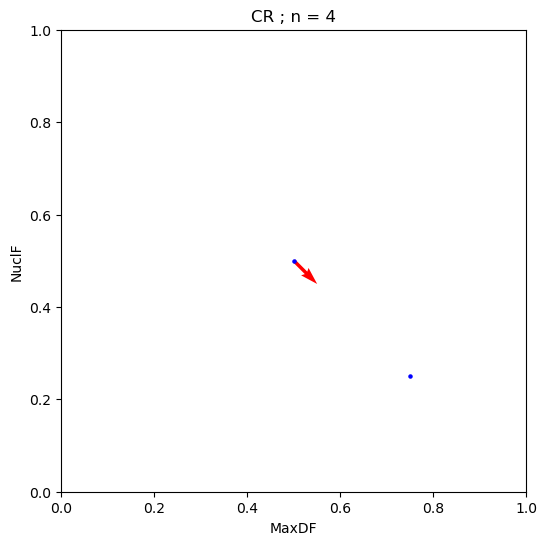

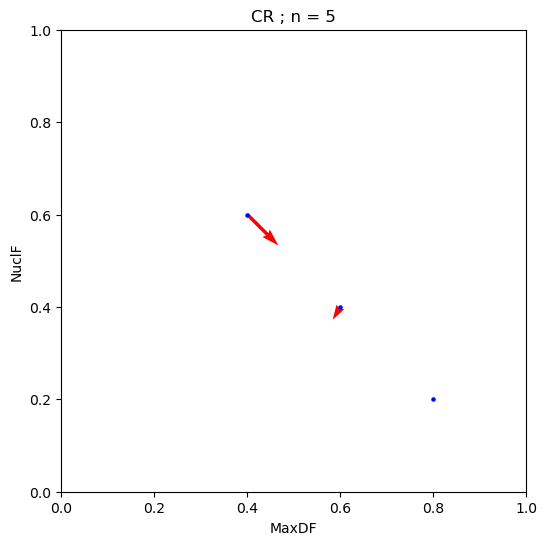

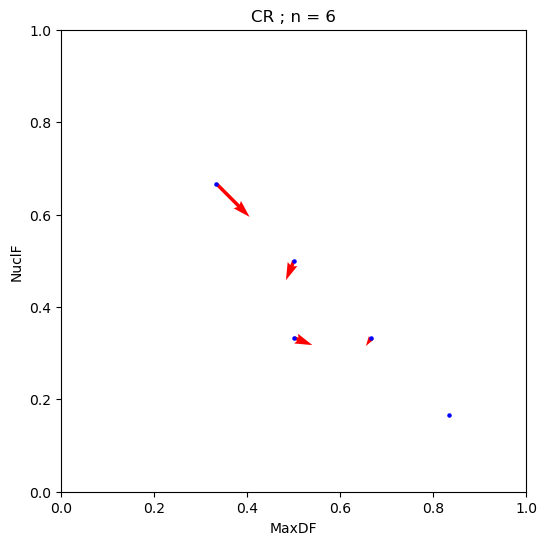

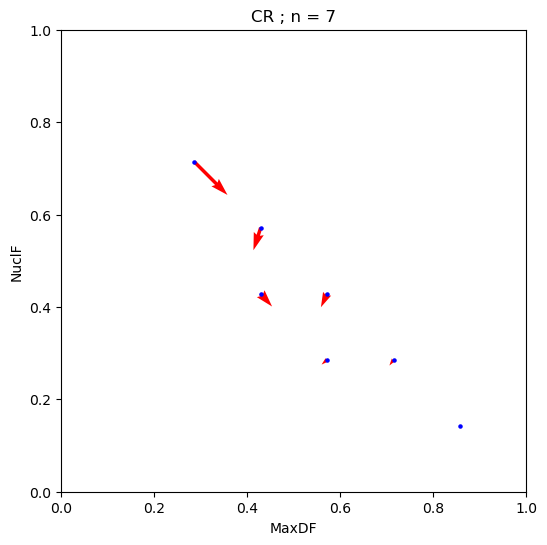

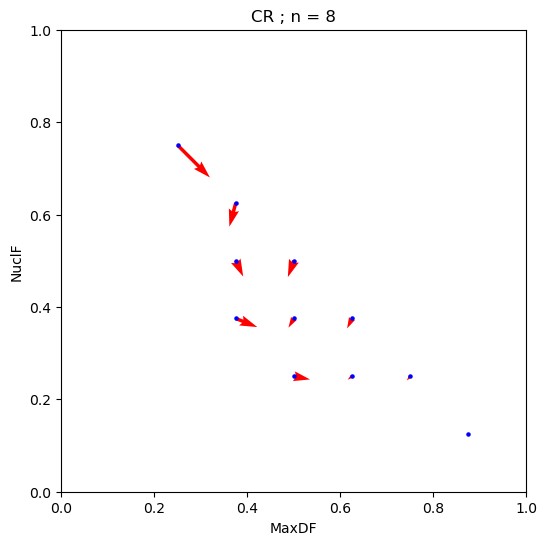

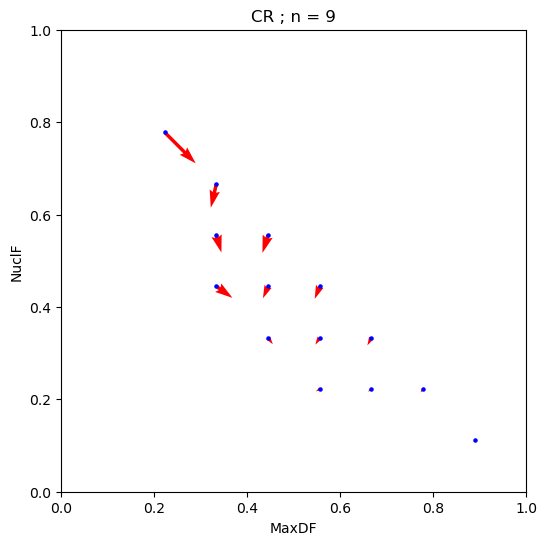

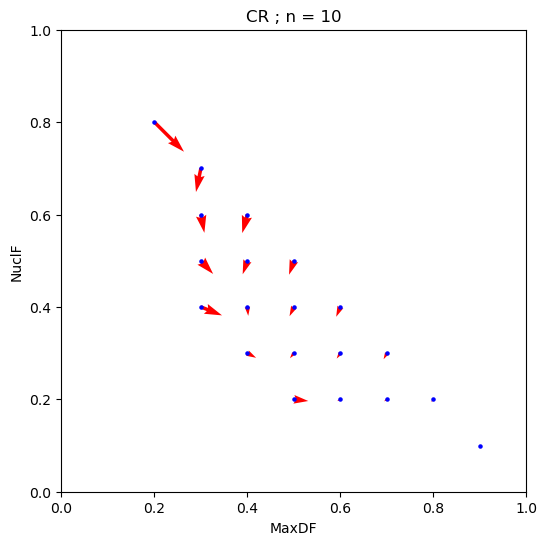

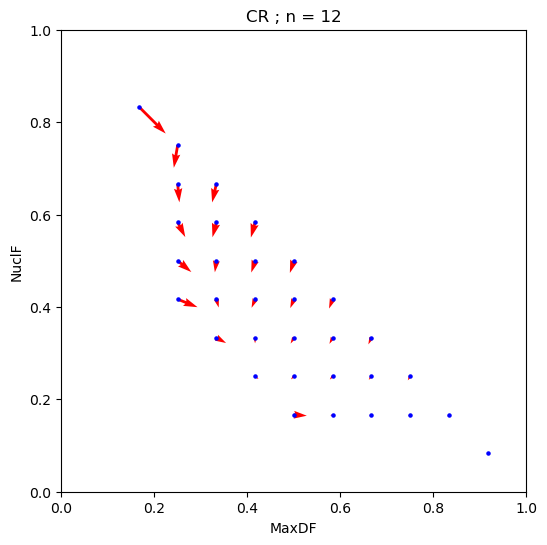

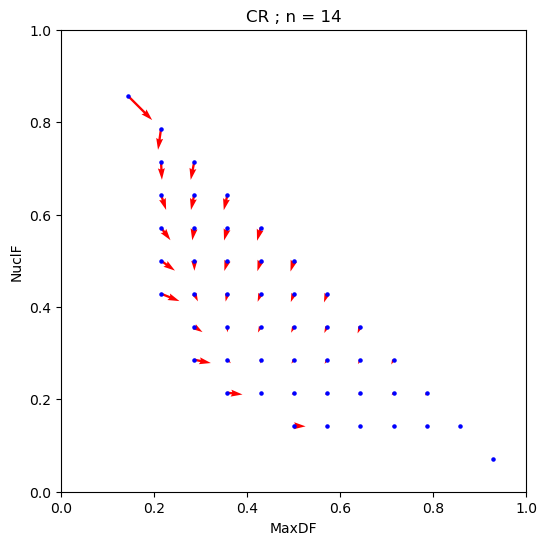

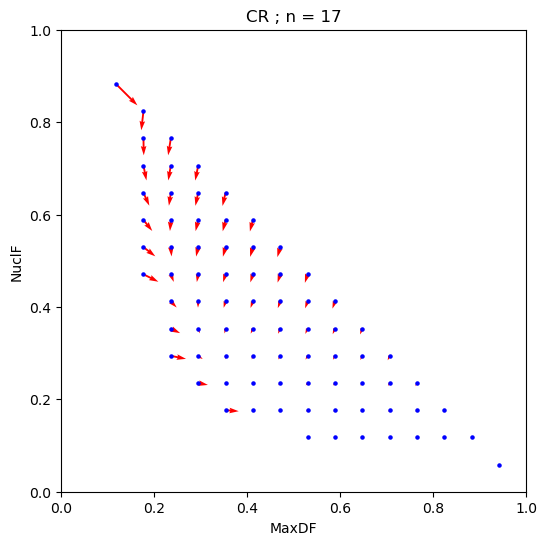

In [206]:
plots_quiver('CR', dict_groups_cr, [3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 17], size_fig=6)